In [1]:
import glob
import os
import re
import pickle

import datatable as dt
import numpy as np
import pandas as pd

from datetime import datetime

import tensorflow as tf
from tensorflow.keras import models, layers, Input
from tensorflow.keras import backend as K
from tensorflow.python.keras.callbacks import ModelCheckpoint

from tqdm import tqdm


from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if 1 == len(physical_devices):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Wczytanie danych

In [3]:
with open('embeddings_100.pkl', 'rb') as file:
    weights = pickle.load(file)
word2idx = {}
with open('word2idx.pkl', 'rb') as file:
    word2idx = pickle.load(file)

In [4]:
def create_data(file_path, files_extension, data_percent):
    X1, X2, Y = [], [], []
    max = 0
    
    columns_to_drop = ["C0", "puuid", "bigger_region", "region", "tier", "champion_rarity", "champion_tier"]
    
    print('Creating data:')
    files = glob.glob(file_path + '/*.' + files_extension)
    files = files[:len(files)*data_percent//100]
    
    for file in tqdm(files):
        df = dt.fread(file).to_pandas()
        df.drop(columns = columns_to_drop, axis=1, inplace=True)
        df.replace('', 'null', inplace=True)
        
        if pd.unique(df.placement).shape[0] != 8:
            continue
    
        teams = []
        for place in range(1, 9): 
            team = df.where(df["placement"] == place).dropna()
            team.drop(columns=["placement"], inplace=True)
            team = team.apply(lambda row: ' '.join(row.fillna('').astype(str)), axis=1)
            
            team_word = ' '.join(team).split()
            team_vec = [weights[word2idx[word]-1] if word != 'null' 
                        else np.zeros(100, dtype=np.float32) for word in team_word ]
            team_vec = np.array(team_vec, dtype=np.float32)
    
            max = team_vec.shape[0] if team_vec.shape[0] > max else max
            teams.append(team_vec)
    
        for team_1 in range(8): 
            for team_2 in range(8):
                if team_1 == team_2:
                    continue
                X1.append(teams[team_1])
                X2.append(teams[team_2])
                if team_1 < team_2:
                    Y.append(1)
                else:
                    Y.append(-1)
                    
    print("Aligning data:")
    for i in tqdm(range(len(X1))):
        to_add = max - X1[i].shape[0]
        aaa = np.zeros((to_add, 100), dtype=np.float32)
        X1[i] = np.vstack((X1[i], aaa))

        to_add = max - X2[i].shape[0]
        aaa = np.zeros((to_add, 100))
        X2[i] = np.vstack((X2[i], aaa), dtype=np.float32)
        
    print("Converting lists to numpy arrays:")
    X1, X2, Y = np.array(X1), np.array(X2), np.array(Y)

    print("Success")
    return X1, X2, Y


In [5]:
file_path = '../data_scraping/04.04.2024'
files_extension = 'csv'
data_percent = 10
X1, X2, Y = create_data(file_path, files_extension, data_percent)

Creating data:


100%|████████████████████████████████████████████████████████████████████████████████| 841/841 [00:18<00:00, 44.63it/s]


Aligning data:


100%|█████████████████████████████████████████████████████████████████████████| 46984/46984 [00:01<00:00, 28038.88it/s]


Converting lists to numpy arrays:
Success


In [6]:
X1.shape

(46984, 91, 100)

In [7]:
X2.shape

(46984, 91, 100)

In [8]:
Y.shape

(46984,)

### Sieć syjamska

In [9]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

In [10]:
data_cut = 46984
data_cut = 30000
valid_data = int(0.15 * data_cut)
print(data_cut, valid_data)

30000 4500


In [11]:
valid_X1 = X1[data_cut-valid_data:data_cut:]
valid_X2 = X2[data_cut-valid_data:data_cut:]
valid_Y = Y [data_cut-valid_data:data_cut:]

X1 = X1[:data_cut-valid_data]
X2 = X2[:data_cut-valid_data]
Y = Y[:data_cut-valid_data]

In [12]:
print(X1.shape)
print(valid_X1.shape)

(25500, 91, 100)
(4500, 91, 100)


In [13]:
input_shape = (X1.shape[1], X1.shape[2], 1)


In [14]:
# Base Network
base_network = models.Sequential(name='Base_Network')

base_network.add(Input(shape=input_shape))

base_network.add(layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu', name='Conv2D_1'))
base_network.add(layers.BatchNormalization())
base_network.add(layers.MaxPooling2D((2, 2)))

base_network.add(layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu', name='Conv2D_2'))
base_network.add(layers.BatchNormalization())
base_network.add(layers.MaxPooling2D((2, 2)))

base_network.add(layers.Flatten())

base_network.add(layers.Dropout(0.5))
base_network.add(layers.Dense(128))

In [15]:
# Siamese Network
input_a = Input(shape=input_shape, name='Team 1')
input_b = Input(shape=input_shape, name='Team 2')

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# distance = layers.Lambda(euclidean_distance, name='Euclidean_Distance')([processed_a, processed_b])
# sub = layers.Subtract(name = 'Subtract')([processed_a, processed_b])
concat = layers.Concatenate(name='Concatenate')([processed_a, processed_b])

output = layers.Dense(1, activation='tanh', name='Output')(concat)

model_siamese = models.Model(inputs=[input_a, input_b], outputs=output, name='Siamese_Network')

# model_siamese.compile(loss=contrastive_loss, optimizer='adam', metrics=["accuracy"])
model_siamese.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

model_siamese.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team 1 (InputLayer)            [(None, 91, 100, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Team 2 (InputLayer)            [(None, 91, 100, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Base_Network (Sequential)      (None, 128)          4334304     ['Team 1[0][0]',                 
                                                                  'Team 2[0][0]']   

In [16]:
epoch = 1000
time = datetime.now().strftime('%Y-%m-%d_%H%M%S')
checkpoint_path = f'cp/{time}/{epoch}.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0)

In [17]:
model_siamese.fit([X1, X2], Y, 
                  epochs=epoch, batch_size=160, 
                  shuffle=True, verbose=True, 
                  validation_split=0.1, callbacks=[checkpoint])

Epoch 1/1000
144/144 [==============================] - 14s 74ms/step - loss: 1.5474 - accuracy: 0.3717 - val_loss: 1.7106 - val_accuracy: 0.4690
Epoch 2/1000
144/144 [==============================] - 10s 69ms/step - loss: 1.5810 - accuracy: 0.2929 - val_loss: 1.3927 - val_accuracy: 0.3702
Epoch 3/1000
144/144 [==============================] - 10s 70ms/step - loss: 1.3149 - accuracy: 0.2990 - val_loss: 1.3143 - val_accuracy: 0.3494
Epoch 4/1000
144/144 [==============================] - 11s 77ms/step - loss: 1.2667 - accuracy: 0.3462 - val_loss: 1.3081 - val_accuracy: 0.3353
Epoch 5/1000
144/144 [==============================] - 12s 80ms/step - loss: 1.3043 - accuracy: 0.3831 - val_loss: 1.3328 - val_accuracy: 0.3843
Epoch 6/1000
144/144 [==============================] - 12s 80ms/step - loss: 1.2720 - accuracy: 0.3614 - val_loss: 1.3365 - val_accuracy: 0.3431
Epoch 7/1000
144/144 [==============================] - 13s 89ms/step - loss: 1.2882 - accuracy: 0.3369 - val_loss: 1.3181 -

In [18]:
model_siamese.evaluate([valid_X1, valid_X2], valid_Y)

141/141 [==============================] - 2s 12ms/step - loss: 1.0658 - accuracy: 0.3453


[1.0657782554626465, 0.3453333377838135]

In [20]:
predictions = np.round(model_siamese.predict([valid_X1, valid_X2]))

141/141 [==============================] - 1s 7ms/step


In [21]:
print(np.unique(predictions))

[-1.  1.]


In [22]:
predicted_labels = np.round(predictions)

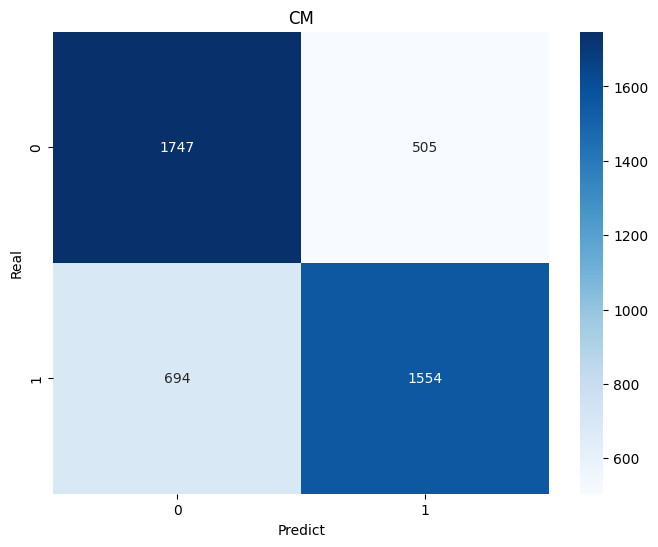

              precision    recall  f1-score   support

          -1       0.72      0.78      0.74      2252
           1       0.75      0.69      0.72      2248

    accuracy                           0.73      4500
   macro avg       0.74      0.73      0.73      4500
weighted avg       0.74      0.73      0.73      4500



In [23]:
cm = confusion_matrix(valid_Y, predicted_labels, labels=[-1, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('CM')
plt.show()

print(classification_report(valid_Y, predicted_labels))